# **Secondary Stock Data - Feature Filtering and Optimization Using Correlation Matrix and VIF Notebook**
## In this notebook we will take our secondary stock data that has been previously preprocessed in sec_stock_preprocessing.ipynb and apply a method called VIF (Variance Inflation Factor) as well as a triangular correlation matrix to optimize our list of lagged features based on our target of the Closing Price for our data.  In other parts of this project it has been shown that there is extremely high collinearity with a lot of our features with our target, creating a lot of data leakage.  This will really skew our model results, so it is something we need to look at now before we get too far along.  Once we optimize our features our models will be much more efficient, as well as using this refined list of features to generate our secondary stocks for better cointegration tests at later parts of the project. 

#### As usual let's start by bringing in the libraries and logic necessary for reading in our file.

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression

#### Now let's read in our notebook and take a look; we will need the unscaled version of our preprocessed secondary stock data.

In [2]:
# Now let's access the main core_stock_data.csv file
csv_path = os.path.join(project_root, 'data', 'sec_stock_unscaled.csv')
sec_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
print(sec_stock_data.head())
print(sec_stock_data.shape)

           ticker   Close_sec  Volume_sec    Open_sec    High_sec     Low_sec  \
Date                                                                            
2019-03-14    RMD  101.000000    972500.0  102.570000  102.570000  100.959999   
2019-03-15    RMD  100.370003   2279400.0  100.900002  101.730003  100.199997   
2019-03-18    RMD   97.400002   1915700.0  100.360001  100.610001   96.940002   
2019-03-19    RMD   97.900002   1101100.0   97.660004   98.190002   97.070000   
2019-03-20    RMD   98.809998   1467600.0   99.129997  100.800003   98.449997   

             SMA_sec     EMA_sec    RSI_sec   BBM_sec  ...  \
Date                                                   ...   
2019-03-14  104.9046  101.000000  63.818062  104.9046  ...   
2019-03-15  104.9046  100.975294  63.818062  104.9046  ...   
2019-03-18  104.9046  100.835087  63.818062  104.9046  ...   
2019-03-19  104.9046  100.719985  63.818062  104.9046  ...   
2019-03-20  104.9046  100.645084  63.818062  104.9046  ...  

#### We need to first set up the Correlation Matrix, and will start with a threshold of 0.95.  Doing the correlation matrix first will allow us to filter out the first batch of features which will set us up nicely for our VIF calculations.  First though let's drop our ticker column as it is not in the right format to be processed by the following calculations.  We also need to introduce our target in our Close Price (Close_sec), as all of the correlations will be based on relationships with this feature.

In [3]:
# Setting up our target for the correlation
target = 'Close_sec'

# Dropping unnecessary features, this portion to be edited as multiple runs of these models are configured.
# We will drop Close_sec, just not here.
cols_to_drop = ['ticker', 'Open_sec', 'High_sec', 'Low_sec', 'SMA_sec',
                'EMA_sec', 'BBM_sec', 'BBU_sec', 'BBL_sec',
                'Momentum_30_sec', 'Momentum_1_sec_Lag_1', 'Momentum_1_sec_Lag_2',
                'MACD_Lag_Std_1_3', 'Momentum_3_sec_Lag_2', 'Momentum_3_sec_Lag_3',
                'Momentum_1_sec_Lag_3', 'Momentum_1_sec', 'Momentum_3_sec',
                'Momentum_7_sec', 'Momentum_3_Lag_Avg_1_3_sec']

cols_now = [col for col in cols_to_drop if col in sec_stock_data.columns]
sec_stock_data_for_corr = sec_stock_data.drop(columns = cols_now)

# Calculate the correlation of each feature with the target
corr_with_target = sec_stock_data_for_corr.corr()[target].abs()

# Set a correlation threshold with the target 
corr_threshold_with_target = 0.25

# Filter features that have a decent correlation with the target
selected_features = corr_with_target[corr_with_target > corr_threshold_with_target].index

# Make sure our target in Close_sec isn't included in the list of selected features since we are dropping it
selected_features = selected_features.drop(target, errors='ignore')

# Print correlation results for selected features
#print(f"Features that correlate well with the target ({target}):\n{corr_with_target[selected_features]}")

# Now we will instantiate a new variable and drop the target Close_sec before running the correlation matrix
sec_stock_data_for_corr = sec_stock_data_for_corr.drop(columns = [target])

# Set up the correlation matrix for the selected features (after filtering by target correlation)
corr_matrix = sec_stock_data_for_corr[selected_features].corr().abs()

# Set the pairwise correlation threshold
corr_threshold = 0.85

# Set up a triangular matrix to identify features with high pairwise correlation
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

selected_features = corr_with_target[corr_with_target > corr_threshold_with_target].index

selected_features = [feature for feature in selected_features if feature != target]

final_corr_with_target = corr_with_target[selected_features].sort_values(ascending = False)
print(f"Features sorted by correlation with target ({target}):\n{final_corr_with_target}")

print(f"Number of remaining features after correlation matrix filtering:\n{len(selected_features)}")



Features sorted by correlation with target (Close_sec):
Close_sec_Lag_1          0.998609
High_sec_Lag_1           0.998545
Low_sec_Lag_1            0.998539
Open_sec_Lag_1           0.998445
Close_Lag_Avg_1_3_sec    0.997856
                           ...   
MACD_Hist_Avg_1_3_sec    0.472103
Open_Lag_Std_1_3_sec     0.287336
Close_Lag_Std_1_3_sec    0.287072
Low_Lag_Std_1_3_sec      0.266599
High_Lag_Std_1_3_sec     0.258735
Name: Close_sec, Length: 85, dtype: float64
Number of remaining features after correlation matrix filtering:
85


#### Good start, we filtered down to 85 features from 153 so we did a nice job of not over-filtering.  That will give our VIF (Variance Inflation Factor) a good pool to work with and we can manually step that threshold and adjust it until we find the set of features we like.  Let's get that VIF Calculation up and running.

In [4]:
# Let's set up our VIF Calculation here.  we will make it as a function so we can tune our threshold as needed.

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

# Filter data for VIF calculation
sec_data_for_vif = sec_stock_data[selected_features]

# Calculate VIF for the remaining features
vif_result = calculate_vif(sec_data_for_vif)

# Set a VIF threshold 
vif_threshold = 10

# Filter features that have VIF below the threshold
filtered_vif_result = vif_result[vif_result['VIF'] < vif_threshold]

final_features = filtered_vif_result['Feature']

# Print final selected features
print(f"Number of final selected features: {len(final_features)}")

print(f"VIF values of selected features:\n{filtered_vif_result.sort_values(by = 'VIF', ascending = False)}")



c:\Users\ryanm\Desktop\Portfolio-Proj-WK\DL-Strategies\DL-Strat\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Number of final selected features: 6
VIF values of selected features:
                        Feature       VIF
76   Momentum_1_Lag_Std_1_3_sec  7.999026
79   Momentum_7_Lag_Std_1_3_sec  7.759133
74       ATR_14_Lag_Std_1_3_sec  6.402666
77   Momentum_3_Lag_Std_1_3_sec  5.584117
81  Momentum_30_Lag_Std_1_3_sec  5.516449
83  Momentum_50_Lag_Std_1_3_sec  5.461889


#### We have a final list of 6 features, down from our original 153, that have been optimized according to our target according to their rate of collinearity.  Due to time restrictions we will just manually implement these in various areas in our project for now.  Later as time allows we will explore other methodologies (RFECV/Ridge, Boruta with RandomForest, etc.) to see if the results differ.

#### We have tested and filtered for multicollinearity, however we need to make sure we didn't remove features that carry predictability with our target.  Let's look at a MIS (Mutual Information Scores) Regression model real quick to ascertain the predictive power of each of the remaining features.  We will want to establish a balance between collinearity and prediction power for our final set of features.

In [5]:
#  Set up our X and y for the model, using our final_features for the X.
X_final = sec_stock_data[final_features]
y = sec_stock_data[target]

# Calculate the MI scores for the selected features
mi_scores = mutual_info_regression(X_final, y)

# Create a DataFrame to display the scores
mi_scores_df = pd.DataFrame({
    'Feature' : final_features,
    'MI_Score' : mi_scores
}).sort_values(by = 'MI_Score', ascending = False)

# Display the MI scores for each feature
print(mi_scores_df)


                        Feature  MI_Score
76   Momentum_1_Lag_Std_1_3_sec  0.460931
79   Momentum_7_Lag_Std_1_3_sec  0.445523
77   Momentum_3_Lag_Std_1_3_sec  0.441928
81  Momentum_30_Lag_Std_1_3_sec  0.433063
83  Momentum_50_Lag_Std_1_3_sec  0.429557
74       ATR_14_Lag_Std_1_3_sec  0.362834


#### Let's also plot the scores we just retrieved from our MIS to see them as well.

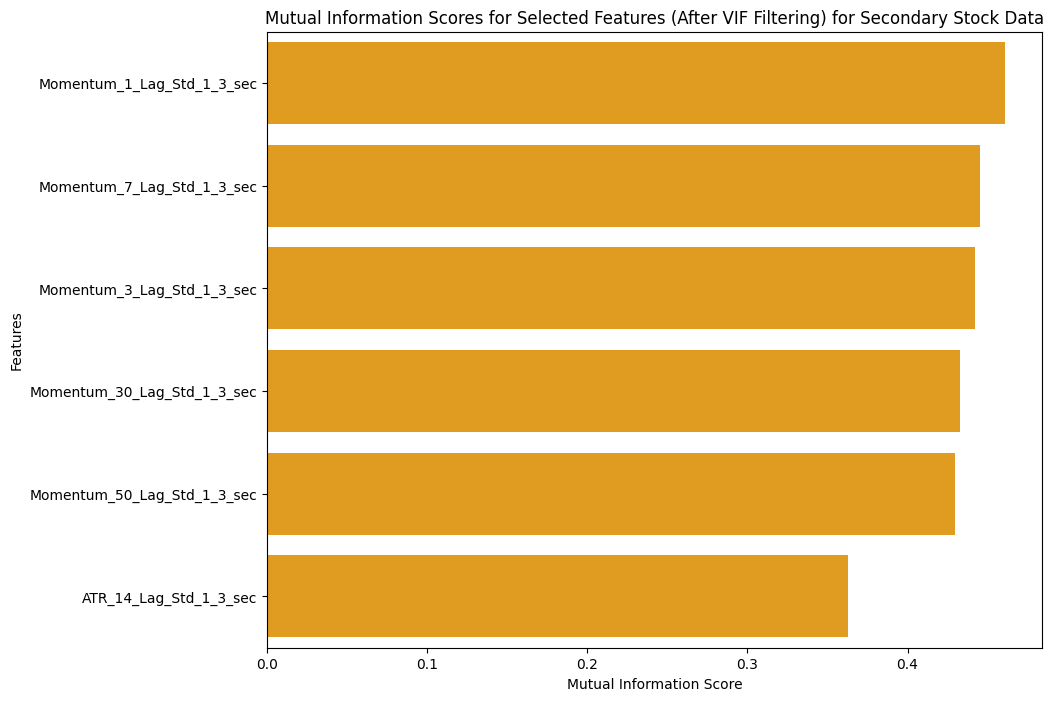

In [6]:
plt.figure(figsize = (10,8))

sns.barplot(x = 'MI_Score', y = 'Feature', data = mi_scores_df, color = 'orange')
plt.title('Mutual Information Scores for Selected Features (After VIF Filtering) for Secondary Stock Data')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

#### This is what I was aiming for, a balance (or close to it anyways).  Note mulitple prunings have been made in order to acquire the end product above, where I would compare MIS feature scores and VIF feature scores and see which VIF scores were highest as well as which of the same features had noticeably low MIS scores.  I then dropped them, and lowered the VIF threshold until I obtained the desired '10' as well as the MIS balance for the final set of features.

#### In this notebook we used correlation matrix and VIF (Variance Inflation Factor) to filter down and score our features against our target feature in Closing Price (Close_Sec), then used afterwards MIS (Mutual Information Scores) to make sure our selected features from VIF had stable predictability.  We ended up with 10 features that we will manually implement where needed now in our project.